1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Permissions](#Permissions)
3. [SageMaker Training Job](#SageMaker-Training-Job)  
    1. [Training with Native TensorFlow](#NativeTF)  
    2. [Training with Optimized TensorFlow](#OptimizedTF)  
    3. [Analysis](#Analysis)  

# Compile and Train the GPT2 Model using the Transformers Trainer API with the SST2 Dataset for Single-Node Multi-GPU Training

## SageMaker Training Compiler Overview

SageMaker Training Compiler is a capability of SageMaker that makes these hard-to-implement optimizations to reduce training time on GPU instances. The compiler optimizes Deep Learning (DL) models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training. 

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. Bring your deep learning models to SageMaker and enable SageMaker Training Compiler to accelerate the speed of your training job on SageMaker ML instances for accelerated computing. 

For more information, see [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) in the *Amazon SageMaker Developer Guide*.

## Introduction

In this demo, you'll use Hugging Face's `transformers` and `datasets` libraries with Amazon SageMaker Training Compiler to train the `gpt-2` model on the `Stanford Sentiment Treebank v2 (SST2)` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

**NOTE:** You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the TensorFlow-based kernels, `Python 3 (TensorFlow x.y Python 3.x CPU Optimized)` or `conda_tensorflow_p36` respectively.

**NOTE:** This notebook uses two `ml.p3.8xlarge` instances that have multiple GPUs. If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

# Development Environment 

## Installation

This example notebook requires the **SageMaker Python SDK v2.70.0** and **transformers v4.11.0**.

In [2]:
!pip install sagemaker botocore boto3 awscli --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p37/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install transformers --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 3.1 MB 5.6 MB/s            
     |████████████████████████████████| 61 kB 1.3 MB/s              
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
  Using cached tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p37/bin/python -m pip install --upgrade pip' command.


In [8]:
import botocore
import boto3
import sagemaker
import transformers
import pandas as pd

print(f"sagemaker: {sagemaker.__version__}")
print(f"transformers: {transformers.__version__}")

sagemaker: 2.63.2
transformers: 4.12.5


### SageMaker environment 


In [9]:
import sagemaker

sess = sagemaker.Session()

# SageMaker session bucket -> used for uploading data, models and logs
# SageMaker will automatically create this bucket if it does not exist
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::875423407011:role/SageMakerRole
sagemaker bucket: sagemaker-us-west-2-875423407011
sagemaker session region: us-west-2


In [15]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

## SageMaker Training Job

To create a SageMaker training job, we use a `HuggingFace` estimator. Using the estimator, you can define which fine-tuning script should SageMaker use through `entry_point`, which `instance_type` to use for training, which `hyperparameters` to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the `HuggingFace` Deep Learning Container, uploads your training script, and downloads the data from `sagemaker_session_bucket` into the container at `/opt/ml/input/data`.

In the following section, you learn how to set up two versions of the SageMaker `HuggingFace` estimator, a native one without the compiler and an optimized one with the compiler.

### Training Setup

In [40]:
# Here we configure the training job. Please configure the appropriate options below:

EPOCHS = 140


# Choose between Causal Language Model and Masked Language Model
LANGUAGE_MODELING_LOSS = "clm"  # or "clm"

MODEL_NAME = "gpt2"
TOKENIZER_NAME = "gpt2"
MODEL_CONFIG = "model_type"
SEQ_LEN = 128

# For more information about the options, please look into the training scripts

# SageMaker Training Compiler currently only supports training on GPU
# Select Instance type for training
INSTANCE_TYPE = "ml.p3.8xlarge"  # ml.p3.8xlarge is easily available. However, p3.16xlarge provides better performance.
NUM_GPUS_PER_INSTANCE = 4


<a id='NativeTF'></a>

### Training with Native TensorFlow

The batch size below is the maximum batch we could fit into the memory of an Nvidia V100 GPU (P3). If you change the model, instance type or sequence length etc., please experiment to find the largest batch size that will fit into memory. 

This example uses a modified version of HuggingFace training script `run_clm.py`, which you can find inside the `scripts` folder. 



In [41]:
from sagemaker.huggingface import HuggingFace

native_batch_size = 48
learning_rate_native = float("1.25e-5")
scaled_learning_rate = learning_rate_native * NUM_GPUS_PER_INSTANCE

# hyperparameters are passed to the training entrypoint as arguments
hyperparameters = {
    "model_name_or_path": MODEL_NAME,
    "output_dir": "/opt/ml/model",
    "dataset_name": "glue",
    "dataset_config_name": "sst2",
    "do_train": True,
    "do_eval": True,
    "per_device_train_batch_size": native_batch_size,
    "learning_rate": scaled_learning_rate,
    "max_seq_length": SEQ_LEN,
    "num_train_epochs": EPOCHS,
    "overwrite_output_dir": True,
    "save_strategy": "no",
    "logging_strategy": "epoch",
}

# configure the training job
native_estimator = HuggingFace(
    entry_point=f"run_{LANGUAGE_MODELING_LOSS}.py",
    source_dir="./scripts",
    instance_type=INSTANCE_TYPE,
    base_job_name=f"{MODEL_NAME.upper()}-{native_batch_size}batch-{EPOCHS}epoch-{SEQ_LEN}seq",
    instance_count=1,
    role=role,
    volume_size=100,
    py_version="py37",
    transformers_version="4.11.0",
    tensorflow_version="2.5.1",
    hyperparameters=hyperparameters,
    disable_profiler=True,  # Disabling SageMaker Profiler to avoid overheads during benchmarking
    debugger_hook_config=False,  # Disabling SageMaker Debugger to avoid overheads during benchmarking
)

# start the training job
native_estimator.fit(wait=False)
native_estimator.latest_training_job.name

'GPT2-48batch-140epoch-128seq-2021-12-06-14-21-02-730'

<a id='OptimizedTF'></a>

### Training with Optimized TensorFlow

Compilation through Training Compiler changes the memory footprint of the model. Note that if you want to change the batch size, you must adjust the learning rate appropriately.

**Note:** We recommend you to turn the SageMaker Debugger's profiling and debugging tools off when you use compilation to avoid additional overheads.


In [42]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

# SageMaker Training Compiler has increased the memory consumption of the model leading to decrease in batch size.
hyperparameters["per_device_train_batch_size"] = 32

# The original LR was set for a batch of 48. Here we are scaling learning rate with batch size.
hyperparameters["learning_rate"] = (
    learning_rate_native * NUM_GPUS_PER_INSTANCE / 48 * hyperparameters["per_device_train_batch_size"]
)

# configure the training job
optimized_estimator = HuggingFace(
    entry_point=f"run_{LANGUAGE_MODELING_LOSS}.py",
    compiler_config=TrainingCompilerConfig(),
    source_dir="./scripts",
    instance_type=INSTANCE_TYPE,
    base_job_name=f"{MODEL_NAME.upper()}XLA-{hyperparameters['per_device_train_batch_size']}batch-{EPOCHS}epoch-{SEQ_LEN}seq",
    instance_count=1,
    role=role,
    volume_size=100,
    py_version="py37",
    transformers_version="4.11.0",
    tensorflow_version="2.5.1",
    hyperparameters=hyperparameters,
    disable_profiler=True,  # Disabling SageMaker Profiler to avoid overheads during benchmarking
    debugger_hook_config=False,  # Disabling SageMaker Debugger to avoid overheads during benchmarking
)

# start the training job
optimized_estimator.fit(wait=False)
optimized_estimator.latest_training_job.name

'GPT2XLA-32batch-140epoch-128seq-2021-12-06-14-21-03-365'

### Wait for training jobs to complete


In [29]:
native_estimator = HuggingFace.attach(native_estimator.latest_training_job.name)
optimized_estimator = HuggingFace.attach(optimized_estimator.latest_training_job.name)


2021-12-06 13:36:40 Starting - Preparing the instances for training
2021-12-06 13:36:40 Downloading - Downloading input data
2021-12-06 13:36:40 Training - Training image download completed. Training in progress.
2021-12-06 13:36:40 Uploading - Uploading generated training model
2021-12-06 13:36:40 Completed - Training job completed

2021-12-06 13:48:10 Starting - Preparing the instances for training
2021-12-06 13:48:10 Downloading - Downloading input data
2021-12-06 13:48:10 Training - Training image download completed. Training in progress.
2021-12-06 13:48:10 Uploading - Uploading generated training model
2021-12-06 13:48:10 Completed - Training job completed


## Analysis

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new HuggingFace estimator. For example:

```python
huggingface_estimator = HuggingFace.attach("<your_huggingface_training_job_name>")
```

### Load logs of the training job *with* SageMaker Training Compiler

In [30]:
%%capture optimized

# access the logs of the optimized training job
optimized_estimator.sagemaker_session.logs_for_job(optimized_estimator.latest_training_job.name)

### Load logs of the training job *without* SageMaker Training Compiler

In [31]:
%%capture native

# access the logs of the native training job
native_estimator.sagemaker_session.logs_for_job(native_estimator.latest_training_job.name)

### Create helper functions for analysis

In [32]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt


def _summarize(captured):
    final = []
    for line in captured.stdout.replace("#010", "").replace("]", "\n").replace("-", "").split("\n"):
        cleaned = line.strip()
        if (
            cleaned.startswith("ETA")
            or "*" * 5 in cleaned
            or "ms/step" in cleaned
            or "Epoch" in cleaned
            or ("INFO" in cleaned and "=" in cleaned)
        ):
            final.append(cleaned)
            print(cleaned)
    return final


def make_sense(string):
    try:
        return literal_eval(string.split(chr(27))[0])
    except:
        pass


def summarize(summary):
    final = {"train": {}, "eval": {}}
    phase = "train"
    for line in summary:
        if "Epoch" in line:
            epoch = literal_eval(line.split(" ")[1].split("/")[0])
            if epoch not in final[phase]:
                final[phase][epoch] = {"loss": [], "ms/step": -1}
        elif line.startswith("ETA"):
            try:
                extract = line[line.index("loss:") : line.index("loss:") + 49]
                values = [i for i in extract.split(" ") if make_sense(i)]
                loss = values[0].split(chr(27))[0]
                final[phase][epoch]["loss"].append(loss)
            except:
                pass
        elif "ms/step" in line:
            avg_step_latency = make_sense(
                [i for i in line.split(" ") if "ms/step" in i][0].replace("ms/step", "")
            )
            final[phase][epoch]["ms/step"] = avg_step_latency
        elif "*" in line:
            return final
            phase = "eval"
            epoch = 0
            final[phase][0] = {"loss": [], "ms/step": -1}
    return final

### Plot Optimized vs Native Training Step Latency

Visualize average step latency and see potential savings.

In [35]:
# Average step latency for the native TensorFlow training
n = summarize(_summarize(native))
native_latency = [n["train"][x]["ms/step"] for x in list(n["train"])]

# Average step latency for the optimized TensorFlow training
# o = summarize(_summarize(optimized))
# optimized_latency = [o["train"][x]["ms/step"] for x in list(o["train"])]

# train_epochs = [int(x) for x in list(n["train"])]
# from statistics import mean

# speedup_per_epoch = []

# for i in range(len(train_epochs)):
#     j = native_latency[i]
#     k = optimized_latency[i]
#     speedup_per_epoch.append((j - k) / j)

# # Calculate percentage speedup of optimized TensorFlow over native TensorFlow
# avg_speedup = "{}%".format(round(mean(speedup_per_epoch), 2) * 100)
# %matplotlib inline

# plt.title("Training Epoch Latency \n (Lower is better)")
# plt.ylabel("Epoch Latency (ms)")
# plt.plot(native_latency, label="Baseline TF")
# plt.plot(optimized_latency, label="SM Training Compiler-enhanced TF")
# plt.xlabel("Train epochs \n  ====> {} Compiler savings <====".format(avg_speedup))
# plt.legend()

Epoch 1/35
ETA: 43:52  loss: 5.5459#015 2/32 [>.............................
ETA: 16s  loss: 5.3421  #015 3/32 [=>............................
ETA: 15s  loss: 5.2169#015 4/32 [==>...........................
ETA: 15s  loss: 5.1424#015 5/32 [===>..........................
ETA: 14s  loss: 5.0736#015 6/32 [====>.........................
ETA: 14s  loss: 5.0254#015 7/32 [=====>........................
ETA: 13s  loss: 4.9772#015 8/32 [======>.......................
ETA: 13s  loss: 4.9370#015 9/32 [=======>......................
ETA: 12s  loss: 4.9065#01510/32 [========>.....................
ETA: 12s  loss: 4.8786#01511/32 [=========>....................
ETA: 11s  loss: 4.8504#01512/32 [==========>...................
ETA: 10s  loss: 4.8248#01513/32 [===========>..................
ETA: 10s  loss: 4.8010#01514/32 [============>.................
ETA: 9s  loss: 4.7805 #01515/32 [=============>................
ETA: 9s  loss: 4.7600#01516/32 [==============>...............
ETA: 8s  loss: 4.7419#0151

### Convergence of Training Loss

SageMaker Training Compiler does not affect the model convergence behavior. Here, we see the decrease in training loss is similar with and without SageMaker Training Compiler


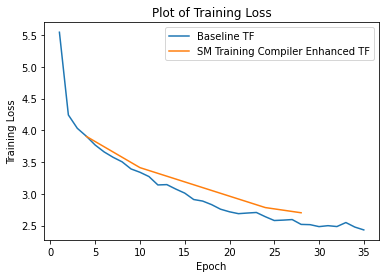

In [36]:
def get_loss_across_epochs(data_summary):
    loss = []
    epochs = []
    for epoch, value in data_summary["train"].items():
        if value["loss"]:
            epochs.append(epoch)
            loss.append(literal_eval(value["loss"][0]))
    epochs, loss = zip(*sorted(zip(epochs, loss)))
    return epochs, loss


native_epochs, native_losses = get_loss_across_epochs(n)

%matplotlib inline

plt.title("Plot of Training Loss")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.plot(native_epochs, native_losses, label="Baseline TF")
optimized_epochs, optimized_losses = get_loss_across_epochs(o)
plt.plot(optimized_epochs, optimized_losses, label="SM Training Compiler Enhanced TF")
plt.legend()

### Total Billable Time

Finally, the decrease in total training time results in a decrease in the billable seconds from SageMaker

In [37]:
def BillableTimeInSeconds(name):
    describe_training_job = (
        optimized_estimator.sagemaker_session.sagemaker_client.describe_training_job
    )
    details = describe_training_job(TrainingJobName=name)
    return details["BillableTimeInSeconds"]

In [38]:
Billable = {}
Billable["Native"] = BillableTimeInSeconds(native_estimator.latest_training_job.name)
Billable["Optimized"] = BillableTimeInSeconds(optimized_estimator.latest_training_job.name)
pd.DataFrame(Billable, index=["BillableSecs"])

,Native,Optimized
BillableSecs,1617,1578


In [39]:
speedup = (Billable["Native"] - Billable["Optimized"]) * 100 / Billable["Native"]
print(f"SageMaker Training Compiler integrated TensorFlow was {int(speedup)}% faster in summary.")

SageMaker Training Compiler integrated TensorFlow was 2% faster in summary.


## Clean up

Stop all training jobs launched if the jobs are still running.

In [ ]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(optimized_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.